Setting Default Cache to specified path

In [1]:
import os
os.environ['TRANSFORMERS_CACHE'] = "D:/transformer_cache/"
os.environ['HF_DATASETS_CACHE'] = "D:/transformer_cache/"

Importing the cnn_dailymail dataset and printing its columns

In [2]:
from datasets import load_dataset

dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")
print(f"Features: {dataset['train'].column_names}")

Features: ['article', 'highlights', 'id']


Printing first 500 characters of the article at index [1] and its corresponding summary

In [3]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


We are restricting the input size to 2000 characters and we store a sample input text at index [1] in "sample text"

In [4]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

Creating our tokenizer that splits the input text into sentences

In [5]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

We use the first three sentences as our summary baseline to compare the generated summaries against

In [6]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])
summaries["baseline"] = three_sentence_summary(sample_text)

Loading the GPT-2 model. The model can be used to generate summaries by appending a TL;DR at the end of the input text, which is done in the below code. 
Max generated summary length is set to 512. clean_up_tokenization removes extra spaces generated during tokenization.

In [7]:
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

C:\Users\USER\anaconda3\lib\site-packages\transformers\utils\hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Loading the T5 model and creating a smiliar pipeline.
T5 is a text to text model and can be used for summarization by providing the input as "summarize: <ARTICLE>". We can directly laod T5 for summarization using pipeline() without worrying about formatting the inputs.

In [11]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Loading the BART model and creating a similiar pipeline.
BART uses an encoder-decoder architecture and is trained to reconstruct corrupted inputs.
We use the facebook/bart-large-cnn checkpoint, which has been fine-tuned on the CNN/daily mail dataset.

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Loading the PEGASUS model. It has an encoder-decoder architecture. Its pre-training objective is to reconstruct masked sentences.
The model has the <n> token for newlines hence sent_tokenize(), which splits into sentences is not required.

In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

C:\Users\USER\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


We print the summaries stored in dataset, the baseline summary and the summaries generated by GPT-2, T5, BART and PEGASUS and compare them qualitatively.

In [14]:
#print("ARTICLE")
#print(dataset["train"][1]["article"][:2000])
#print("")
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")
for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
To get to the jail, you go up a flight of stairs, pass a metal detector, and go down a hall.
The inmates are so scared that they'll be thrown in jail for not turning up your appointment.
The first room to the right is 

We now compare the summaries generated using the ROUGE metric

In [11]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

C:\Users\USER\AppData\Local\Temp\ipykernel_23300\2048908469.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


In [12]:
!pip install rouge_score

We compare the models using the ROUGE metric on the CNN/dailymail dataset.

In [12]:
from datasets import load_metric
import pandas as pd
rouge_metric = load_metric("rouge",trust_remote_code=True)
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.271186,0.051724,0.152542,0.271186
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842


We evaluate the baseline using ROUGE metric

In [13]:
def evaluate_summaries_baseline(dataset, metric,column_text="article",column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
    references=dataset[column_summary])
    score = metric.compute()
    return score

We use only 500 data points to evaluate the baseline as doing so on the entire dataset is computationally expensive.

In [14]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(500))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388588,0.168604,0.242256,0.351425


We now evaluate the PEGASUS model

In [18]:
from tqdm import tqdm
import torch

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [16]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

#device="cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

C:\Users\USER\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

#device="cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
#score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
#                                   model, tokenizer, batch_size=8)
#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
#pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████| 63/63 [4:05:47<00:00, 234.09s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.012722,0.000559,0.012589,0.012641


In [ ]:
# hide_input 
pd.DataFrame(rouge_dict, index=["pegasus"])

# Training a Summarization Model

We use the SAMSum dataset developed by Samsung, which consists of a collection of dialogues along with brief summaries

In [16]:
dataset_samsum = load_dataset("samsum",trust_remote_code=True)
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Using the latest cached version of the module from C:\Users\USER\.cache\huggingface\modules\datasets_modules\datasets\samsum\f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e (last modified on Wed Jul  3 19:21:09 2024) since it couldn't be found locally at samsum, or remotely on the Hugging Face Hub.


Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


We evaluate PEGASUS on SAMSum dataset BEFORE fine-tuning.

In [21]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

#device="cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from datasets import load_metric
rouge_metric = load_metric("rouge",trust_remote_code=True)
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
tokenizer, column_text="dialogue",
column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|█████████████████████████████████████████████████████████████████████████████| 103/103 [6:15:02<00:00, 218.47s/it]


NameError: name 'rouge_names' is not defined

ROUGE scores before fine-tuning on SAMSum dataset

In [23]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015564,0.000294,0.015572,0.015588


# Fine-tuning PEGASUS on SAMSum dataset

Plotting dialogue and summary token lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


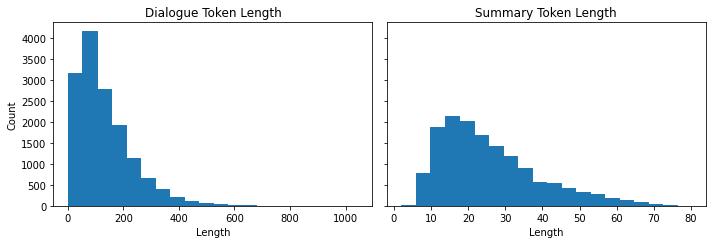

In [19]:
import matplotlib.pyplot as plt
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

We convert the input to tokens. We set max token length for dialogues and summaries to 1024 and 128.

In [20]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
        truncation=True)
        return {"input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]}
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

C:\Users\USER\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


We define the data collator. The data collator collects all tensors from the batch and stacks them up. It shifts the summary labels at the decoder side by 1 to implement "teacher forcing". In addition, ignoring of padding tokens is implemented.

In [21]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

We now carry out training

In [39]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
per_device_train_batch_size=1, per_device_eval_batch_size=1,
weight_decay=0.01, logging_steps=10, push_to_hub=True,
evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
gradient_accumulation_steps=16)
# from transformers import TrainingArguments, Trainer
# training_args = TrainingArguments(
# output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
# per_device_train_batch_size=1,
# weight_decay=0.01, logging_steps=10, push_to_hub=True,
# evaluation_strategy='steps', eval_steps=500, save_steps=1e6)

In [26]:
from huggingface_hub import notebook_login
notebook_login()

In [41]:
trainer = Trainer(model=model, args=training_args,
tokenizer=tokenizer, data_collator=seq2seq_data_collator,
train_dataset=dataset_samsum_pt["train"],
eval_dataset=dataset_samsum_pt["validation"])

In [42]:
trainer.train()
score = evaluate_summaries_pegasus(
dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
batch_size=2, column_text="dialogue", column_summary="summary")
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 3.43 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

The training could not be implemented due to lack of GPU resources. However, it is expected that there would be an improvement in the ROUGE score of the model that was fine-tuned on the SAMSum dataset, over the PEGASUS model before fine-tuning.

ROUGE scores AFTER fine-tuning.

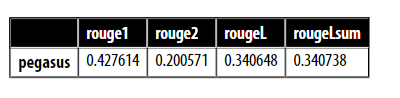